__mlmachine - Hyperparameter Tuning with Bayesian Optimization__

1. [Bayesian Optimization for Multiple Estimators in One Shot](#Bayesian-Optimization-for-Multiple-Estimators-in-One-Shot)
    1. [Prepare Data](#Prepare-Data)
    1. [Reload Feature Selection Results](#Reload-Feature-Selection-Results)
    1. [Outline Our Feature Space](#Outline-Our-Feature-Space)
    1. [Run the Bayesian Optimization Job](#Run-the-Bayesian-Optimization-Job)
1. [Results Analysis](#Results-Analysis)
    1. [Results Summary](#Results-Summary)
    1. [Model Optimization Assessment](#Model-Optimization-Assessment)
    1. [Parameter Selection Assessment](#Parameter-Selection-Assessment)
1. [Model Reinstantiation](#Model-Reinstantiation)
    1. [Top Model Identification](#Top-Model-Identification)
    1. [Putting the Models to Use](#Putting-the-Models-to-Use)


In [1]:
# standard libary and settings
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    KBinsDiscretizer,
    RobustScaler,
    PolynomialFeatures,
)
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from category_encoders import WOEEncoder, TargetEncoder, CatBoostEncoder
from hyperopt import hp
from xgboost import XGBClassifier
import mlmachine as mlm
from mlmachine.data import titanic
from mlmachine.features.preprocessing import (
    DataFrameSelector,
    PandasTransformer,
    PandasFeatureUnion,
    GroupbyImputer,
    KFoldEncoder,
    DualTransformer,
)

c:\users\petersont\appdata\local\continuum\anaconda3\envs\petersont\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


---
# Bayesian Optimization for Multiple Estimators in One Shot
---
<br><br>
Bayesian optimization is typically described as an advancement beyond exhaustive grid searches, and rightfully so. This hyperparameter tuning strategy succeeds by using prior information to inform future parameter selection for a given estimator. Check out Will Koerhsen's article on Medium for an excellent overview of the package.
<br><br>

mlmachine uses hyperopt as a foundation for performing Bayesian optimization, and takes the functionality of hyperopt a step further through a simplified workflow that allows for optimization of multiple models in single process execution. In this article, we are going to optimize four classifiers:
- `LogisticRegression()`
- `XGBClassifier()`
- `RandomForestClassifier()`
- `KNeighborsClassifier()`

<a id = 'Bayesian-Optimization-for-Multiple-Estimators-in-One-Shot'></a>

---
## Prepare Data
---
<br><br>
We have two preparatory steps to complete prior to hyperparameter tuning. First, we need to prepare our dataset. For those who have read [Part 1](https://github.com/petersontylerd/mlmachine/blob/master/notebooks/mlmachine_part_1.ipynb), [Part 2](https://github.com/petersontylerd/mlmachine/blob/master/notebooks/mlmachine_part_2.ipynb), and [Part 3](https://github.com/petersontylerd/mlmachine/blob/master/notebooks/mlmachine_part_3.ipynb) of this article series, nothing in this block of code below is new:
<br><br>


<a id = 'Prepare-Data'></a>

In [2]:
df_train, df_valid = titanic()

ordinal_encodings = {"Pclass": [1, 2, 3]}

mlmachine_titanic_train = mlm.Machine(
    data=df_train,
    target="Survived",
    remove_features=["PassengerId","Ticket","Name","Cabin"],
    identify_as_continuous=["Age","Fare"],
    identify_as_count=["Parch","SibSp"],
    identify_as_nominal=["Embarked"],
    identify_as_ordinal=["Pclass"],
    ordinal_encodings=ordinal_encodings,
    is_classification=True,
)

mlmachine_titanic_valid = mlm.Machine(
    data=df_valid,
    remove_features=["PassengerId","Ticket","Name","Cabin"],
    identify_as_continuous=["Age","Fare"],
    identify_as_count=["Parch","SibSp"],
    identify_as_nominal=["Embarked"],
    identify_as_ordinal=["Pclass"],
    ordinal_encodings=ordinal_encodings,
    is_classification=True,
)

### impute pipeline
impute_pipe = PandasFeatureUnion([
    ("age", make_pipeline(
        DataFrameSelector(include_columns=["Age","SibSp"]),
        GroupbyImputer(null_column="Age", groupby_column="SibSp", strategy="mean")
    )),
    ("fare", make_pipeline(
        DataFrameSelector(include_columns=["Fare","Pclass"]),
        GroupbyImputer(null_column="Fare", groupby_column="Pclass", strategy="mean")
    )),
    ("embarked", make_pipeline(
        DataFrameSelector(include_columns=["Embarked"]),
        PandasTransformer(SimpleImputer(strategy="most_frequent"))
    )),
    ("diff", make_pipeline(
        DataFrameSelector(exclude_columns=["Age","Fare","Embarked"])
    )),
])

mlmachine_titanic_train.data = impute_pipe.fit_transform(mlmachine_titanic_train.data)
mlmachine_titanic_valid.data = impute_pipe.transform(mlmachine_titanic_valid.data)

# transform pipe
polynomial_pipe = PandasFeatureUnion([
    ("polynomial", make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["continuous"]),
        PandasTransformer(PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)),
    )),
    ("diff", make_pipeline(
        DataFrameSelector(exclude_mlm_dtypes=["continuous"]),
    )),
])

mlmachine_titanic_train.data = polynomial_pipe.fit_transform(mlmachine_titanic_train.data)
mlmachine_titanic_valid.data = polynomial_pipe.transform(mlmachine_titanic_valid.data)

mlmachine_titanic_train.update_dtypes()
mlmachine_titanic_valid.update_dtypes()

### encode & bin pipeline
encode_pipe = PandasFeatureUnion([
    ("nominal", make_pipeline(
        DataFrameSelector(include_columns=mlmachine_titanic_train.data.mlm_dtypes["nominal"]),
        PandasTransformer(OneHotEncoder(drop="first")),
    )),
    ("ordinal", make_pipeline(
        DataFrameSelector(include_columns=list(ordinal_encodings.keys())),
        PandasTransformer(OrdinalEncoder(categories=list(ordinal_encodings.values()))),
    )),
    ("bin", make_pipeline(
        DataFrameSelector(include_columns=mlmachine_titanic_train.data.mlm_dtypes["continuous"]),
        PandasTransformer(KBinsDiscretizer(encode="ordinal")),
    )),
    ("diff", make_pipeline(
        DataFrameSelector(exclude_columns=mlmachine_titanic_train.data.mlm_dtypes["nominal"] + list(ordinal_encodings.keys())),
    )),
])

mlmachine_titanic_train.data = encode_pipe.fit_transform(mlmachine_titanic_train.data)
mlmachine_titanic_valid.data = encode_pipe.fit_transform(mlmachine_titanic_valid.data)

mlmachine_titanic_train.update_dtypes()
mlmachine_titanic_valid.update_dtypes()

### impute pipeline
target_encode_pipe = PandasFeatureUnion([
    ("target", make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["category"]), 
        KFoldEncoder(
            target=mlmachine_titanic_train.target,
            cv=KFold(n_splits=5, shuffle=True, random_state=0),
            encoder=TargetEncoder,
        ),
    )),
    ("woe", make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["category"]),
        KFoldEncoder(
            target=mlmachine_titanic_train.target,
            cv=KFold(n_splits=5, shuffle=False, random_state=0),
            encoder=WOEEncoder,
        ),
    )),
    ("catboost", make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["category"]),
        KFoldEncoder(
            target=mlmachine_titanic_train.target,
            cv=KFold(n_splits=5, shuffle=False, random_state=0),
            encoder=CatBoostEncoder,
        ),
    )),
    ("diff", make_pipeline(
        DataFrameSelector(exclude_mlm_dtypes=["category"]),
    )),
])

mlmachine_titanic_train.data = target_encode_pipe.fit_transform(mlmachine_titanic_train.data)
mlmachine_titanic_valid.data = target_encode_pipe.transform(mlmachine_titanic_valid.data)

mlmachine_titanic_train.update_dtypes()
mlmachine_titanic_valid.update_dtypes()

### scale values
scale = PandasTransformer(RobustScaler())

mlmachine_titanic_train.data = scale.fit_transform(mlmachine_titanic_train.data)
mlmachine_titanic_valid.data = scale.transform(mlmachine_titanic_valid.data)

>>> category label encoding

	0 --> 0
	1 --> 1



Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.


In [3]:
mlmachine_titanic_train.data

,Age,Age*Fare,Age*Fare_binned_5,Age*Fare_binned_5_catboost_encoded,Age*Fare_binned_5_target_encoded,Age*Fare_binned_5_woe_encoded,Age^2,Age^2_binned_5,Age^2_binned_5_catboost_encoded,Age^2_binned_5_target_encoded,...,Parch,Pclass_ordinal_encoded,Pclass_ordinal_encoded_catboost_encoded,Pclass_ordinal_encoded_target_encoded,Pclass_ordinal_encoded_woe_encoded,Sex_male,Sex_male_catboost_encoded,Sex_male_target_encoded,Sex_male_woe_encoded,SibSp
0,-0.622287,-0.241862,-1.0,-0.061922,0.257553,-0.090433,-0.568680,-0.5,0.196885,0.754887,...,0.0,0.0,-0.089623,0.000000,-0.167183,0.0,0.017268,0.017703,0.000604,1.0
1,0.608483,2.880011,1.0,1.746016,1.330575,1.479878,0.726867,1.0,0.660192,0.000000,...,0.0,-2.0,1.760707,1.370847,1.550231,-1.0,0.996585,0.989747,0.991390,1.0
2,-0.314594,-0.184856,-0.5,-1.034485,-0.868374,-1.118681,-0.309570,-0.5,0.196885,-0.053122,...,0.0,0.0,-0.089623,-0.121216,-0.167183,-1.0,0.996585,0.991811,0.991390,0.0
3,0.377713,1.838762,1.0,1.746016,1.529026,1.479878,0.431320,0.5,-0.550145,-0.358207,...,0.0,-2.0,1.760707,1.518257,1.550231,-1.0,0.996585,1.018386,0.991390,1.0
4,0.377713,-0.092152,0.0,-0.528664,-0.424139,-0.541412,0.431320,0.5,-0.550145,-0.164268,...,0.0,0.0,-0.089623,-0.092714,-0.167183,0.0,0.017268,-0.004054,0.000604,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,-0.237671,-0.007348,0.0,-0.328148,-0.392308,-0.307120,-0.238045,-0.5,0.037256,-0.053122,...,0.0,-1.0,0.976021,0.788897,0.876603,0.0,0.000000,-0.013572,-0.013136,0.0
887,-0.853056,0.260843,0.5,0.447477,0.390087,0.391274,-0.734672,-1.0,1.386391,2.241119,...,0.0,-2.0,1.488058,1.370847,1.319121,-1.0,0.982567,0.989747,0.985342,0.0
888,0.000000,0.426906,0.5,0.447477,0.607692,0.391274,0.000000,0.0,0.584119,0.775099,...,2.0,0.0,0.000000,0.000000,-0.040700,-1.0,0.982567,1.018386,0.985342,1.0
889,-0.314594,0.518013,0.5,0.447477,0.576066,0.391274,-0.309570,-0.5,0.037256,-0.053122,...,0.0,-2.0,1.488058,1.549093,1.319121,0.0,0.000000,-0.013572,-0.013136,0.0


---
## Reload Feature Selection Results
---
<br><br>
As a second preparatory step, we want to perform feature selection for each of our classifiers. For those who read [Part 4](https://github.com/petersontylerd/mlmachine/blob/master/notebooks/mlmachine_part_4.ipynb), nothing in the following block of code is new:
<br><br>


<a id = 'Reload-Feature-Selection-Results'></a>

In [4]:
estimators = [
    LogisticRegression,
    XGBClassifier,
    RandomForestClassifier,
    KNeighborsClassifier,
]

fs = mlmachine_titanic_train.FeatureSelector(
    data=mlmachine_titanic_train.data,
    target=mlmachine_titanic_train.target,
    estimators=estimators,
)
feature_selector_summary = fs.feature_selector_suite(
    sequential_scoring="accuracy",
    sequential_n_folds=0,
    add_stats=True,
    n_jobs=1,
    save_to_csv=True,
)
# feature_selector_summary=pd.read_csv("data/feature_selection_summary.csv", index_col=0)   

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


---
<br><br>
From this result, we extract our dictionary of optimum feature sets for each estimator:
<br><br>


In [5]:
# calculate cross-validation performance
cv_summary = fs.feature_selector_cross_val(
    feature_selector_summary=feature_selector_summary,
    estimators=estimators,
    scoring=["accuracy"],
    n_folds=5,
    step=1,
    n_jobs=4,
    save_to_csv=True,
)
# cv_summary= pd.read_csv("data/cv_summary.csv", index_col=0)

---
<br><br>
The keys are estimator names, and the associated values are lists containing the column names of the best performing feature subset for each estimator. Here is the key/value pairs for `XGBClassifier()`, which used only 10 of the available 43 features to achieve the best average cross-validation accuracy on the validation dataset:
<br><br>


In [6]:
cross_val_feature_dict = fs.create_cross_val_features_dict(
    scoring="accuracy_score",
    cv_summary=cv_summary,
    feature_selector_summary=feature_selector_summary,
)

---
<br><br>
With our processed dataset and optimum feature subsets in hand, it's time to use Bayesian optimization to tune the hyperparameters of our 4 estimators.
<br><br>


---
## Outline Our Feature Space
---
<br><br>
First, we need to establish our feature space for each parameter for each estimator:
<br><br>

<a id = 'Results-Analysis'></a>

In [7]:
# model/parameter space
estimator_parameter_space = {
    "LogisticRegression": {
        "C": hp.loguniform("C", np.log(0.001), np.log(0.2)),
        "penalty": hp.choice("penalty", ["l2"]),
    },
    "XGBClassifier": {
        "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1.0),
        "gamma": hp.uniform("gamma", 0.0, 10),
        "learning_rate": hp.uniform("learning_rate", 0.01, 0.3),
        "max_depth": hp.choice("max_depth", np.arange(2, 20, dtype=int)),
        "min_child_weight": hp.uniform("min_child_weight", 1, 20),
        "n_estimators": hp.choice("n_estimators", np.arange(100, 10000, 1, dtype=int)),
        "subsample": hp.uniform("subsample", 0.3, 1),
    },
    "RandomForestClassifier": {
        "bootstrap": hp.choice("bootstrap", [True, False]),
        "max_depth": hp.choice("max_depth", np.arange(2, 20, dtype=int)),
        "n_estimators": hp.choice("n_estimators", np.arange(100, 10000, 1, dtype=int)),
        "max_features": hp.choice("max_features", ["auto", "sqrt"]),
        "min_samples_split": hp.choice(
            "min_samples_split", np.arange(2, 40, dtype=int)
        ),
        "min_samples_leaf": hp.choice("min_samples_leaf", np.arange(2, 40, dtype=int)),
    },
    "KNeighborsClassifier": {
        "algorithm": hp.choice("algorithm", ["auto", "ball_tree", "kd_tree", "brute"]),
        "n_neighbors": hp.choice("n_neighbors", np.arange(1, 20, dtype=int)),
        "weights": hp.choice("weights", ["distance", "uniform"]),
    },
}

---
<br><br>
The outermost keys of the dictionary are names of classifiers, represented by strings. The associated values are also dictionaries, where the keys are parameter names, represented as strings, and the values are hyperopt sampling distributions from which parameter values will be chosen.
<br><br>


---
## Run the Bayesian Optimization Job
---
<br><br>
Now we're ready to run our Bayesian optimization hyperparameter tuning job. We will use a built-in method belonging to our Machine object called exec_bayes_optim_search(). Let's see mlmachine in action:
<br><br>

<a id = 'Run-the-Bayesian-Optimization-Job'></a>

In [8]:
# execute bayesian optimization grid search
mlmachine_titanic_train.exec_bayes_optim_search(
    estimator_parameter_space=estimator_parameter_space,
    data=mlmachine_titanic_train.data,
    target=mlmachine_titanic_train.target,
    columns=cross_val_feature_dict,
    scoring="accuracy",
    n_folds=5,
    n_jobs=5,
    iters=20,
    show_progressbar=True,
)


####################################################################################################

Tuning LogisticRegression

100%|███████████████████████████████████████████████| 20/20 [00:11<00:00,  1.71trial/s, best loss: 0.19299479003201314]

####################################################################################################

Tuning XGBClassifier

100%|███████████████████████████████████████████████| 20/20 [04:40<00:00, 14.02s/trial, best loss: 0.15938108091143055]

####################################################################################################

Tuning RandomForestClassifier

100%|███████████████████████████████████████████████| 20/20 [06:10<00:00, 18.54s/trial, best loss: 0.17284539576925495]

####################################################################################################

Tuning KNeighborsClassifier

100%|███████████████████████████████████████████████| 20/20 [00:08<00:00,  2.46trial/s, best loss: 0.17504237022158053]

---
<br><br>
Let's review the parameters:
- `estimator_parameter_space`: The dictionary-based feature space we setup above.
- `data`: Our observations.
- `target`: Our target data.
- `columns`: An optional parameter that allows us to subset the input dataset features. Accepts a list of feature names, which will apply equally to all estimators. Also accepts a dictionary, where the keys represent estimator class names and values are lists of feature names to be used with the associated estimator. In this example, we use the latter by passing in the dictionary returned by `cross_val_feature_dict` in the - `FeatureSelector` workflow above.
- `scoring`: The scoring metric to be evaluated.
- `n_folds`: Number of folds to use in cross-validation procedure.
- `iters`: Total number of iterations to run the hyperparameter tuning process. In this example, we run the experiment for 200 iterations.
- `show_progressbar`: Controls whether progress bar displays and actively updates during the course of the process.
<br><br>

Anyone familiar with hyperopt will be wondering where the objective function is. mlmachine abstracts away this complexity. 
<br><br>

The process runtime depends on several attributes, including hardware, the number and type of estimators used, the number of folds, feature selection, and the number of sampling iterations. Runtimes can be quite lengthy. For this reason, `exec_bayes_optim_search()` automatically saves the result of each iteration to a CSV.
<br><br>

# Results Analysis

<a id = 'Results-Analysis'></a>

---
## Results Summary
---
<br><br>
Let's start by loading and reviewing the results:
<br><br>

<a id = 'Results-Summary'></a>

In [9]:
bayes_optim_summary = pd.read_csv("data/bayes_optimization_summary_accuracy.csv", na_values="nan")
bayes_optim_summary

,iteration,estimator,scoring,loss,mean_score,std_score,min_score,max_score,train_time,status,params
0,1,LogisticRegression,accuracy,0.204218,0.795782,0.026768,0.754190,0.825843,1.080047,ok,"{'C': 0.008174796663349533, 'penalty': 'l2', '..."
1,2,LogisticRegression,accuracy,0.210922,0.789078,0.037798,0.720670,0.820225,1.232385,ok,"{'C': 0.007456580176063114, 'penalty': 'l2', '..."
2,3,LogisticRegression,accuracy,0.196384,0.803616,0.027326,0.769663,0.848315,1.175930,ok,"{'C': 0.015197336097355196, 'penalty': 'l2', '..."
3,4,LogisticRegression,accuracy,0.191890,0.808110,0.025218,0.780899,0.842697,1.189311,ok,"{'C': 0.016970348333069277, 'penalty': 'l2', '..."
4,5,LogisticRegression,accuracy,0.196391,0.803609,0.014813,0.786517,0.825843,1.207008,ok,"{'C': 0.03346957219746275, 'penalty': 'l2', 'n..."
...,...,...,...,...,...,...,...,...,...,...,...
795,196,KNeighborsClassifier,accuracy,0.196366,0.803634,0.037666,0.752809,0.848315,1.195285,ok,"{'algorithm': 'auto', 'n_neighbors': 12, 'weig..."
796,197,KNeighborsClassifier,accuracy,0.188500,0.811500,0.039510,0.765363,0.870787,1.237776,ok,"{'algorithm': 'auto', 'n_neighbors': 9, 'weigh..."
797,198,KNeighborsClassifier,accuracy,0.191871,0.808129,0.037196,0.765363,0.865169,1.200201,ok,"{'algorithm': 'brute', 'n_neighbors': 10, 'wei..."
798,199,KNeighborsClassifier,accuracy,0.179562,0.820438,0.030073,0.769663,0.859551,1.213567,ok,"{'algorithm': 'auto', 'n_neighbors': 5, 'weigh..."


---
<br><br>
Our Bayesian optimization log maintains key information about each iteration:
- Iteration number, estimator and scoring metric
- Cross-validation summary statistics
- Iteration training time
- Dictionary of parameters used

This log provides an immense amount of data for us to analyze and evaluate the effectiveness of the Bayesian optimization process.
<br><br>

---
## Model Optimization Assessment
---
<br><br>
First and foremost, we want to see how if performance improved over the iterations.
<br><br>

Let's visualize the `XGBClassifier()` loss by iteration:
<br><br>

<a id = 'Model-Optimization-Assessment'></a>

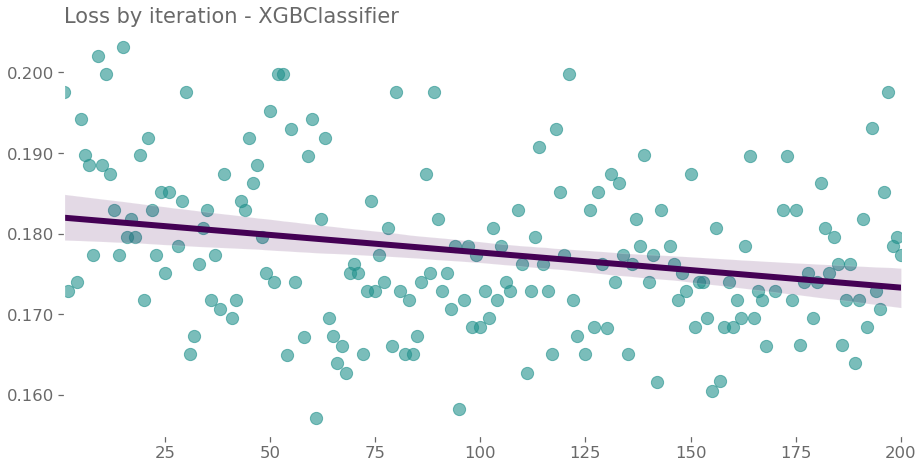

In [10]:
mlmachine_titanic_train.model_loss_plot(
    bayes_optim_summary=bayes_optim_summary,
    estimator_class="XGBClassifier",
)

---
<br><br>
Each dot represents the performance of one of our 200 experiments. The key detail to notice is that the line of best fit has a clear downward slope -  exactly what we want. This means that with each iteration, model performance tends to improve compared to the previous iterations.
<br><br>

---
## Parameter Selection Assessment
---
<br><br>
One of the coolest parts of Bayesian optimization is seeing how parameter selection is optimized.
<br><br>

For each model and for each model's parameters, we can generate a two-panel visual.
<br><br>

For numeric parameters, such as `n_estimators` or `learning_rate`, the two-visual panel includes:
- Parameter selection KDE, overplayed on a theoretical distribution KDE
- Parameter selection by iteration scatter plot, with line of best fit
<br><br>

For categorical parameters, such as loss function, the two-visual panel includes:
- Parameter selection and theoretical distribution bar chart
- Parameter selection by iteration scatter plot, faceted by parameter category

Let's review the parameter selection panels for `KNeighborsClassifier()`:
<br><br>

<a id = 'Parameter-Selection-Assessment'></a>

****************************************************************************************************
* KNeighborsClassifier
****************************************************************************************************


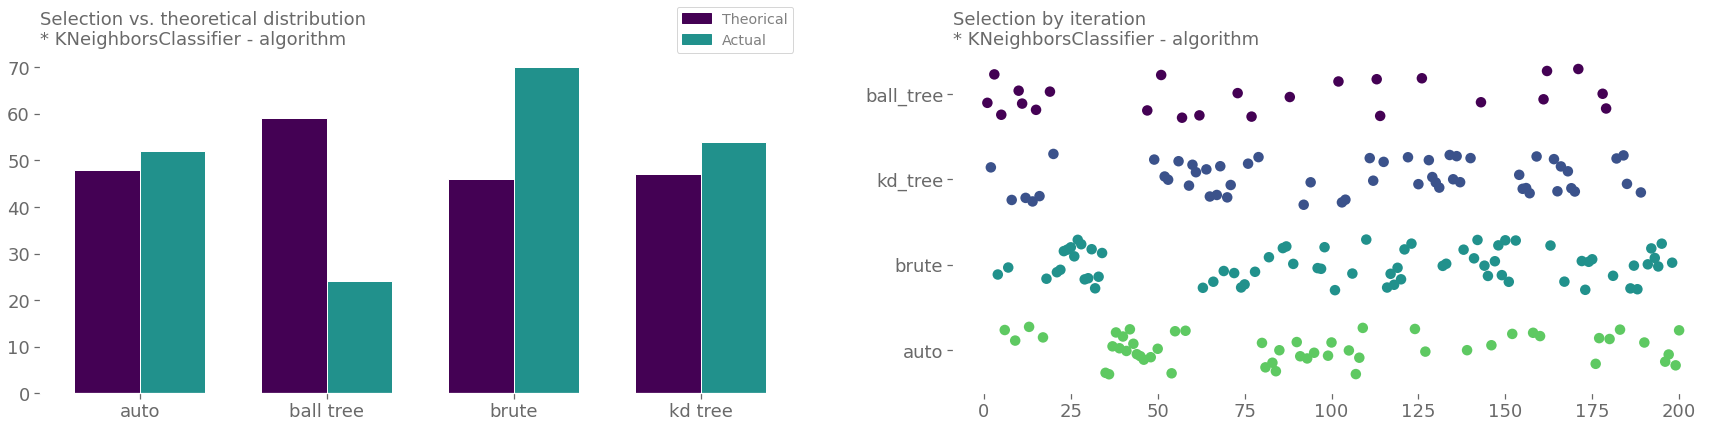

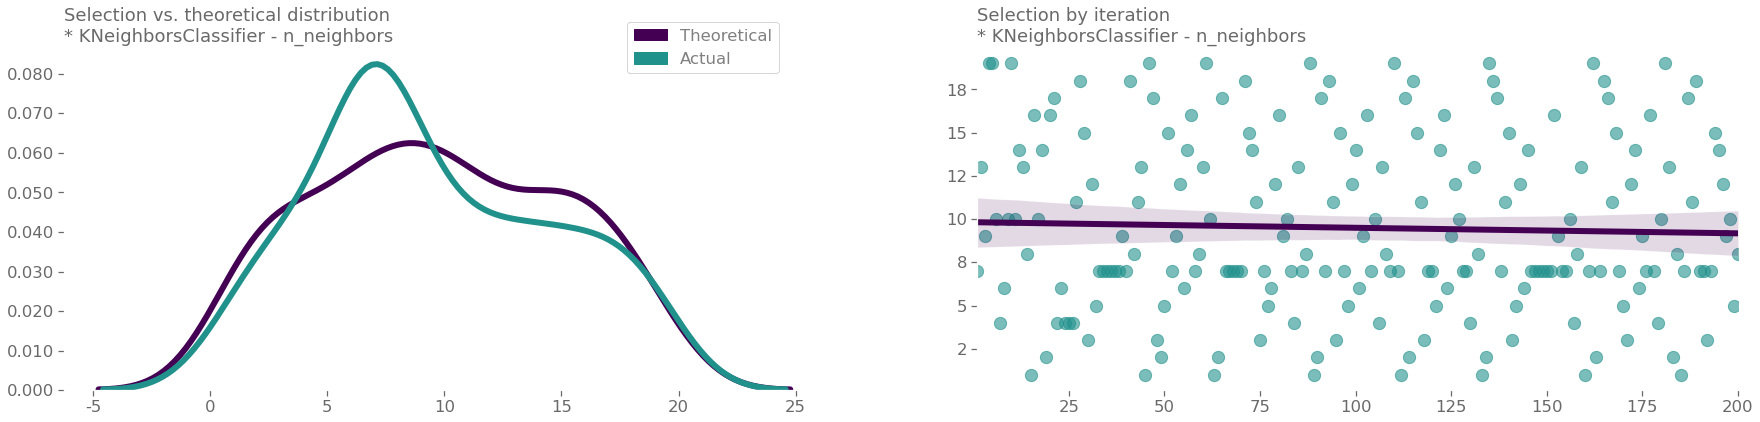

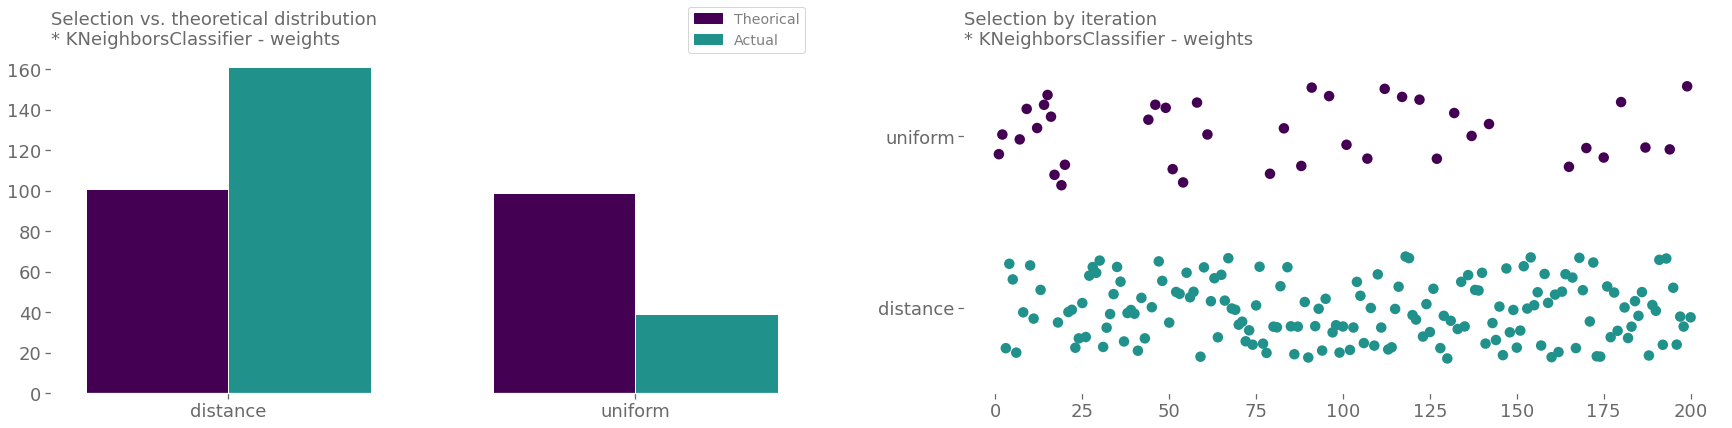

In [11]:
mlmachine_titanic_train.model_param_plot(
    bayes_optim_summary=bayes_optim_summary,
    estimator_class="KNeighborsClassifier",
    estimator_parameter_space=estimator_parameter_space,
    n_iter=200,
)

---
<br><br>
The built-in method `model_param_plot()` cycles through of the estimator's parameters and presents the appropriate panel given each parameter's type. Let's look at a numeric parameter and categorical parameter separately.
<br><br>

First, we'll review the panel for the numeric parameter `n_neighbors`:
<br><br>

<br><br>
![alt text](images/p5_param_panel.jpeg "EDA Panel")
<br><br>

On the left, we can see two overlapping kernel density plots summarizing the actual parameter selections and the theoretical parameter distribution. The purple line corresponds to the theoretical distribution, and, as expected, this curve is smooth and evenly distributed. The teal line corresponds to the actual parameter selections, and it's clearly evident that hyperopt prefers values between 5 and 10. 
<br><br>

On the right, the scatter plot visualizes the `n_neighbors` value selections over the iterations. There is a slight downward slope to the line of best fit, as the Bayesian optimization process hones in on values around 7.
<br><br>

Next, we'll review the panel for the categorical parameter `algorithm`:
<br><br>

<br><br>
![alt text](images/p5_param_panel_2.jpeg "EDA Panel")
<br><br>

On the left, we see a bar chart displaying the counts of parameter selections, faceted by actual parameter selections and selections from the theoretical distribution . The purple bars, representing selections from the theoretical distribution, are more even than the teal bars, representing the actual selection. 
<br><br>

On the right, the scatter plot again visualizes the algorithm value selection over the iterations. There is a clear decrease in selection of "ball_tree" and "auto" in favor of "kd_tree" and "brute" over the the iterations.
<br><br>

---
# Model-Reinstantiation
---

<a id = 'Model-Reinstantiation'></a>

---
## Top Model Identification
---
<br><br>
Our `Machine()` object has a built-in method called `top_bayes_optim_models()`, which identifies the best model for each estimator type based on the results in our Bayesian optimization log.
<br><br>

<a id = 'Top-Model-Identification'></a>

In [13]:
top_models = mlmachine_titanic_train.top_bayes_optim_models(bayes_optim_summary=bayes_optim_summary, num_models=1)
top_models

{'LogisticRegression': [30],
 'XGBClassifier': [61],
 'RandomForestClassifier': [46],
 'KNeighborsClassifier': [109]}

---
<br><br>
With this method, we can identify the top N models for each estimator based on mean cross-validation score. In this experiment, `top_bayes_optim_models()` returns the dictionary below, which tells us that `LogisticRegression()` identified its top model on iteration 30, `XGBClassifier()` on iteration 61, `RandomForestClassifier()` on iteration 46, and `KNeighborsClassifier()` on iteration 109.
<br><br>

In [14]:
mlmachine_titanic_train.top_bayes_optim_models(
    bayes_optim_summary=bayes_optim_summary,
    num_models=1,
)

{'LogisticRegression': [30],
 'XGBClassifier': [61],
 'RandomForestClassifier': [46],
 'KNeighborsClassifier': [109]}

---
## Putting the Models to Use
---
<br><br>
To reinstantiate a model, we leverage our `Machine()` object's built-in method `BayesOptimClassifierBuilder()`. To use this method, we pass in our results log, specify an estimator class and iteration number. This will instantiate a model object with the parameters stored on that record of the log:
<br><br>

<a id = 'Putting-the-Models-to-Use'></a>

In [15]:
model = mlmachine_titanic_train.BayesOptimClassifierBuilder(
    bayes_optim_summary=bayes_optim_summary,
    estimator_class="RandomForestClassifier",
    model_iter=46
)
print(model.custom_model)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=19, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=7,
                       min_weight_fraction_leaf=0.0, n_estimators=4019,
                       n_jobs=4, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


---
<br><br>
The models instantiated with `BayesOptimClassifierBuilder()` use `.fit()` and `.predict()` in a way that should feel quite familiar.
<br><br>

Let's finish this article with a very basic model performance evaluation. We will fit this `RandomForestClassifier()` on the training data and labels, generate predictions with the training data, and evaluate the model's performance by comparing these predictions to the ground-truth:
<br><br>

In [16]:
# fit the model
model.fit(mlmachine_titanic_train.data, mlmachine_titanic_train.target)

# generate predictions
y_pred_train = model.predict(mlmachine_titanic_train.data)

# summarize results
training_accuracy = sum(y_pred_train == mlmachine_titanic_train.target) / len(y_pred_train)
print("RandomForestClassifier, iter = 46 \nTraining accuracy: {:.2%}".format(training_accuracy))

RandomForestClassifier, iter = 46 
Training accuracy: 94.16%
